In [1]:
from __future__ import print_function
import numpy as np
import scipy.io as sio
import pandas as pd
from sklearn.metrics import mean_squared_error

np.random.seed(1337)  # for reproducibility

# from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers.normalization import BatchNormalization
from keras.layers import Convolution2D, MaxPooling2D, AveragePooling2D
from keras.utils import np_utils
from keras import backend as K
import matplotlib.pyplot as plt

%matplotlib inline

Using TensorFlow backend.


In [2]:
# input image dimensions
img_rows, img_cols = 128, 128
# size of pooling area for max pooling
pool_size = (2, 2)
# convolution kernel size
kernel_size = (3, 3)

# Training data, shuffled and split
WB = np.array(sio.loadmat('sandstone_data.mat')['Data'])
Y_data = np.array(sio.loadmat('sandstone_data.mat')['L'])
# Y_data = (Y_data-min(Y_data))/(max(Y_data)-min(Y_data))
X_data = np.reshape(WB,(768,1,img_rows,img_cols))

# Add 267 generated images using image diff
WB_gen_i = np.array(sio.loadmat('image_space.mat')['Data'])
Y_gen_i = np.array(sio.loadmat('image_space.mat')['L'])

WB_gen = [WB_gen_i[4*j+i] for j in range(89) for i in range(3)]
Y_gen = [Y_gen_i[4*j+i] for j in range(89) for i in range(3)]

X_gen = np.transpose(np.reshape(WB_gen,(267,1,img_rows,img_cols)),[0,1,3,2])

#test data
WB1 = sio.loadmat('test_sandstone_data.mat')['Data']
X_test = np.reshape(WB1, (240, 1, img_rows, img_cols))
Y_test = sio.loadmat('test_sandstone_data.mat')['L']
# Y_test = (Y_test-min(Y_test))/(max(Y_test) - min(Y_test))

#normalize label all together to be consistent
label_norm = np.concatenate((Y_data, Y_gen, Y_test), axis=0)
label_norm = (label_norm-min(label_norm))/(max(label_norm)-min(label_norm))
Y_data = label_norm[:768]
Y_gen = label_norm[768:-240]
Y_test = label_norm[-240:]


#Define Traing data and validation data
X_train = np.concatenate((X_data[0:700], X_gen[0:220]), axis=0);
Y_train = np.concatenate((Y_data[0:700], Y_gen[0:220]), axis=0);
X_val = np.concatenate((X_data[700:768], X_gen[220:]), axis=0);
Y_val = np.concatenate((Y_data[700:768], Y_gen[220:]), axis=0);


if K.image_dim_ordering() == 'th':
    X_train = X_train.reshape(X_train.shape[0], 1, img_rows, img_cols)
    X_val = X_val.reshape(X_val.shape[0], 1, img_rows, img_cols)
    X_test = X_test.reshape(X_test.shape[0], 1, img_rows, img_cols)
    input_shape = (1, img_rows, img_cols)
else:
    X_train = X_train.reshape(X_train.shape[0], img_rows, img_cols, 1)
    X_val = X_val.reshape(X_val.shape[0], img_rows, img_cols, 1)
    X_test = X_test.reshape(X_test.shape[0], img_rows, img_cols, 1)
    input_shape = (img_rows, img_cols, 1)
    

X_train = X_train.astype('float32')
X_val = X_val.astype('float32')
X_test = X_test.astype('float32')

print('X_train shape:', X_train.shape)
print(X_train.shape[0], 'train samples')
print(X_val.shape[0], 'validate samples')
print(X_test.shape[0], 'test samples')

X_train shape: (920, 128, 128, 1)
920 train samples
115 validate samples
240 test samples


In [ ]:
plt.imshow(X_gen[3,:].reshape(128,128))

In [ ]:
plt.imshow(X_test[1,:].reshape(128,128))

In [3]:
# CNN

model = Sequential()

model.add(Convolution2D(24, (3, 3), padding='same', input_shape=input_shape))
model.add(Activation('relu'))
model.add(Convolution2D(24, (3, 3), padding='same'))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=pool_size))


model.add(Convolution2D(48, (3, 3), padding='same'))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=pool_size))


model.add(Convolution2D(96, (3, 3), padding='same'))
model.add(Activation('relu'))
model.add(Convolution2D(96, (3, 3), padding='same'))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=pool_size))


model.add(Convolution2D(128, (3, 3), padding='same'))
model.add(Activation('relu'))
model.add(Convolution2D(128, (3, 3), padding='same'))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=pool_size))


model.add(Flatten())
model.add(Dense(1000))
model.add(Activation('relu'))
model.add(Dropout(0.25))
model.add(Dense(100))
model.add(Activation('relu'))
model.add(Dropout(0.25))
model.add(Dense(1))
model.add(Activation('relu'))

model.compile(loss='mse', optimizer='adam', metrics=['mae'])

In [4]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 128, 128, 24)      240       
_________________________________________________________________
activation_1 (Activation)    (None, 128, 128, 24)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 128, 128, 24)      5208      
_________________________________________________________________
activation_2 (Activation)    (None, 128, 128, 24)      0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 64, 64, 24)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 64, 64, 48)        10416     
_________________________________________________________________
activation_3 (Activation)    (None, 64, 64, 48)        0         
__________

In [5]:
from keras.callbacks import EarlyStopping
early_stop = EarlyStopping(monitor='val_loss', min_delta=0, patience=10, verbose=0, mode='min')
model.fit(X_train, Y_train, batch_size=40, epochs=20, verbose=1, validation_data=(X_val, Y_val),
          callbacks=[early_stop])

Train on 920 samples, validate on 115 samples
Epoch 1/20
920/920 [==============================] - 65s - loss: 0.1184 - mean_absolute_error: 0.2560 - val_loss: 0.0398 - val_mean_absolute_error: 0.1784
Epoch 2/20
920/920 [==============================] - 61s - loss: 0.0366 - mean_absolute_error: 0.1541 - val_loss: 0.0163 - val_mean_absolute_error: 0.1051
Epoch 3/20
920/920 [==============================] - 58s - loss: 0.0167 - mean_absolute_error: 0.1017 - val_loss: 0.0050 - val_mean_absolute_error: 0.0518
Epoch 4/20
920/920 [==============================] - 65s - loss: 0.0081 - mean_absolute_error: 0.0657 - val_loss: 0.0037 - val_mean_absolute_error: 0.0480
Epoch 5/20
920/920 [==============================] - 54s - loss: 0.0060 - mean_absolute_error: 0.0555 - val_loss: 0.0024 - val_mean_absolute_error: 0.0387
Epoch 6/20
920/920 [==============================] - 59s - loss: 0.0055 - mean_absolute_error: 0.0531 - val_loss: 0.0012 - val_mean_absolute_error: 0.0270
Epoch 7/20
920/920

training mse: 0.00087502508041
testing mse: 0.00137253555793


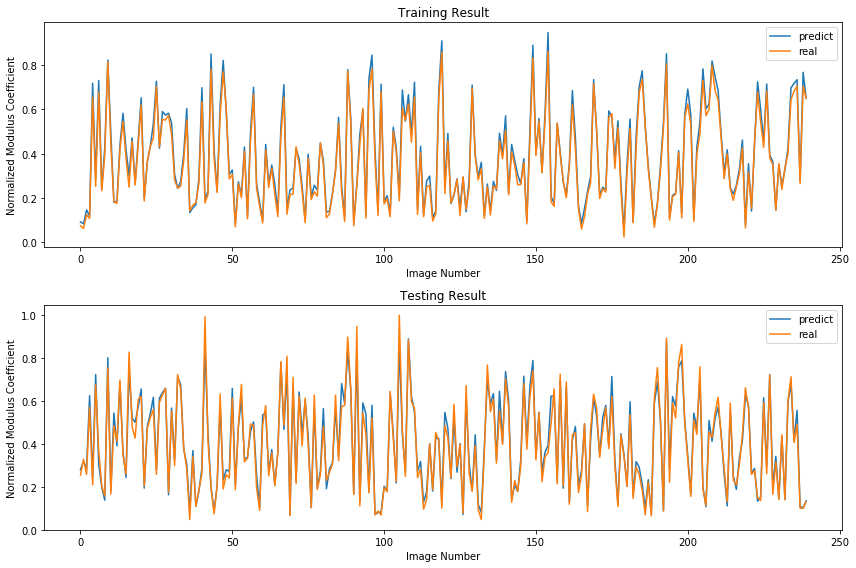

In [6]:
x=[]
num = 240
for i in range(num):
    x.append(i)

fig = plt.figure(figsize=(12,8))
ax1=fig.add_subplot(2,1,1)

train_pred=model.predict(X_train)
print('training mse:', mean_squared_error(Y_train, train_pred))

ax1.plot(x,train_pred[0:num], label='predict')
ax1.plot(x,Y_train[0:num],label='real')
plt.legend()
ax1.set_title('Training Result')
ax1.set_xlabel('Image Number')
ax1.set_ylabel('Normalized Modulus Coefficient')


ax2=fig.add_subplot(2,1,2)

test_pred=model.predict(X_test)
print('testing mse:', mean_squared_error(Y_test, test_pred))

ax2.plot(x,test_pred[0:num], label='predict')
ax2.plot(x,Y_test[0:num],label='real')
plt.legend()
ax2.set_title('Testing Result')
ax2.set_xlabel('Image Number')
ax2.set_ylabel('Normalized Modulus Coefficient')

plt.tight_layout()
plt.savefig('image_space_result.png',dpi=400)

In [ ]:
plt.scatter(Y_test.reshape(-1),test_pred)

In [7]:
model.save('CNN_image_space_model_081217.h5')